# Fine-tuning TimeGPT with Custom Data

This notebook demonstrates how to fine-tune TimeGPT using the Nixtla API. Fine-tuning allows you to adapt TimeGPT's pre-trained capabilities to your specific forecasting needs.

## 1. Install Dependencies

First, let's install all required packages. After running this cell, you'll need to restart the runtime using the menu: Runtime → Restart runtime

In [1]:
%%capture
!pip install --upgrade pip
!pip install nixtla
!pip install 'dask[dataframe]'
!pip install utilsforecast
!pip install pandas numpy matplotlib seaborn

⚠️ **Important**: After running the above cell, please:
1. Click on "Runtime" in the top menu
2. Select "Restart runtime"
3. Click "Yes" to confirm
4. Continue running the cells below

## 2. Import Required Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nixtla import NixtlaClient
from utilsforecast.losses import mae, mse
from utilsforecast.evaluation import evaluate
from datetime import datetime, timedelta

# Configure plotting
sns.set_theme(style="whitegrid")
print("✅ All packages imported successfully")

✅ All packages imported successfully


In [3]:
# Initialize Nixtla client
nixtla_client = NixtlaClient(
    api_key='FAKE'  # Replace with your API key
)
print("✅ Nixtla client initialized")

✅ Nixtla client initialized


## 3. Load and Prepare Data

We'll create a synthetic dataset for demonstration purposes.

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate dates
dates = pd.date_range(start='2020-01-01', end='2023-12-31', freq='M')

# Generate synthetic values with trend and seasonality
t = np.arange(len(dates))
trend = 0.1 * t
seasonal = 10 * np.sin(2 * np.pi * t / 12)  # Annual seasonality
noise = np.random.normal(0, 2, len(dates))

values = 100 + trend + seasonal + noise

# Create DataFrame
df = pd.DataFrame({
    'timestamp': dates,
    'value': values
})

# Display first few rows
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
display(df.head())
print("\n✅ Dataset created successfully")

Dataset Shape: (48, 2)

First few rows:


<ipython-input-4-e226ebac6115>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2020-01-01', end='2023-12-31', freq='M')


,timestamp,value
0,2020-01-31,100.993428
1,2020-02-29,104.823471
2,2020-03-31,110.155631
3,2020-04-30,113.346060
4,2020-05-31,108.591947



✅ Dataset created successfully


## 4. Fine-tune and Generate Forecasts

We'll experiment with different fine-tuning depths to see their impact on forecast accuracy.

In [5]:
# Split data into train and test sets
train = df[:-12]  # Use all but last 12 months for training
test = df[-12:]   # Last 12 months for testing

print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

# Try different fine-tuning depths
depths = [1, 2, 3]  # We'll try depths 1-3

test = test.copy()

for depth in depths:
    print(f"\n📊 Generating forecasts with fine-tuning depth {depth}...")
    # Generate forecasts with fine-tuning
    preds_df = nixtla_client.forecast(
        df=train,
        h=12,                # Forecast horizon (12 months)
        finetune_steps=5,    # Number of fine-tuning iterations
        finetune_depth=depth,# Depth of fine-tuning
        time_col='timestamp',
        target_col='value'
    )

    # Store predictions
    test[f'TimeGPT_depth{depth}'] = preds_df['TimeGPT'].values
    print(f"✅ Depth {depth} forecasts completed")

Training data shape: (36, 2)
Test data shape: (12, 2)

📊 Generating forecasts with fine-tuning depth 1...
✅ Depth 1 forecasts completed

📊 Generating forecasts with fine-tuning depth 2...
✅ Depth 2 forecasts completed

📊 Generating forecasts with fine-tuning depth 3...
✅ Depth 3 forecasts completed


## 5. Evaluate Results

In [6]:
# Add unique_id for evaluation
test['unique_id'] = 0

# Calculate metrics
evaluation = evaluate(
    test,
    metrics=[mae, mse],
    time_col="timestamp",
    target_col="value"
)

print("📈 Evaluation Results:")
display(evaluation)

📈 Evaluation Results:


,unique_id,metric,TimeGPT_depth1,TimeGPT_depth2,TimeGPT_depth3
0,0,mae,1.619589,1.752898,1.891796
1,0,mse,4.401184,4.992459,6.053999


## 6. Visualize Results

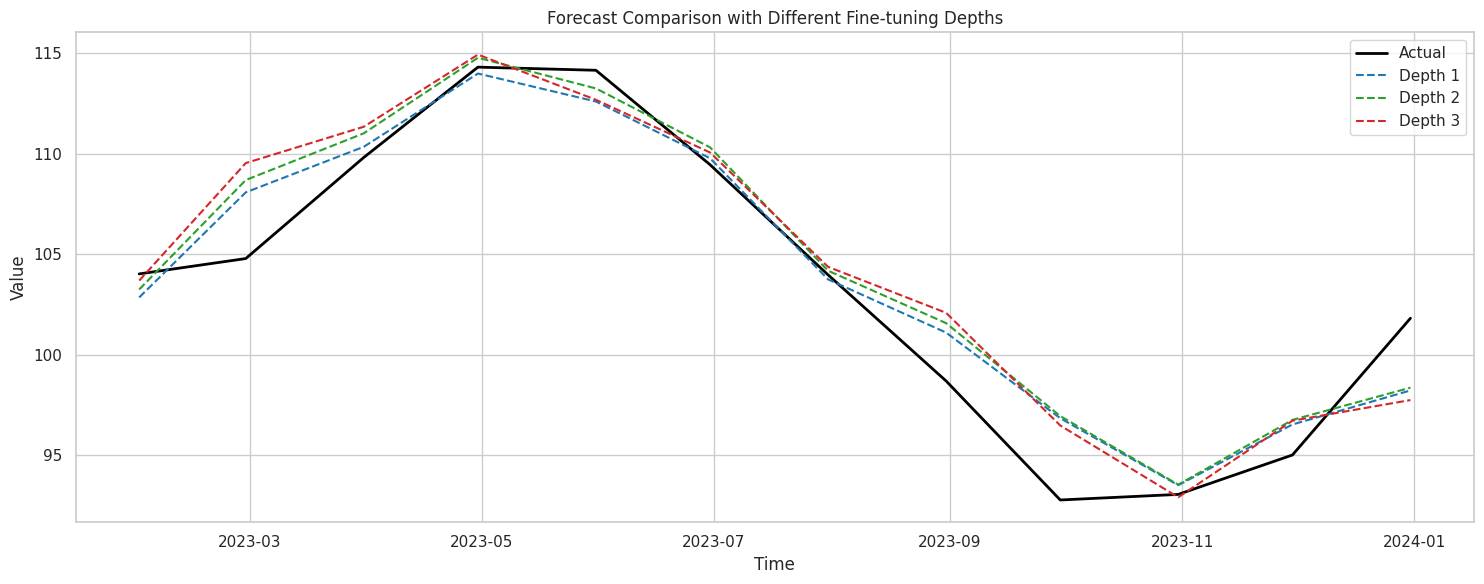

✅ Visualization completed


In [7]:
plt.figure(figsize=(15, 6))

# Plot actual values
plt.plot(test['timestamp'], test['value'], label='Actual', color='black', linewidth=2)

# Plot predictions for each depth
colors = ['#1f77b4', '#2ca02c', '#d62728']
for depth, color in zip(depths, colors):
    plt.plot(test['timestamp'], test[f'TimeGPT_depth{depth}'],
             label=f'Depth {depth}', color=color, linestyle='--')

plt.title('Forecast Comparison with Different Fine-tuning Depths')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Visualization completed")

## Conclusion

This notebook demonstrated TimeGPT fine-tuning with different depths. Key observations:

1. Fine-tuning depth affects model performance
2. Higher depths don't always mean better results
3. The optimal depth depends on your data characteristics

For best results:
- Experiment with different `finetune_steps` and `finetune_depth` values
- Monitor performance metrics to find optimal parameters
- Consider your data size when choosing fine-tuning depth